In [1]:
import glob, os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from collections import Counter

from sklearn.svm import SVR, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import  metrics

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


## Load datasets ##

In [2]:
from types import SimpleNamespace 
from typing import Tuple


class Dataset:
    def __init__(self, path):
        dataset = dict(np.load(path, allow_pickle=True))
        self.X = dataset.pop('X')
        self.y = dataset.pop('y')
        self.meta = dataset.pop('meta')
        
        assert len(dataset) == 0
        
        self.y_binary = np.where(self.y == None, 0, 1)
    
    def normalize(self, mean=None, std=None):
        # TODO: czy powinniśmy normalizować per współrzędna czy globalnie?
        if mean is None:
            mean = np.mean(self.X, axis=0)
            
        if std is None:
            std = np.std(self.X, axis=0, ddof=1)
            
        print(mean.shape, std.shape)
        
        self.X = (self.X - mean) / std
        
        return mean, std
    
    def sample(self, n, balanced=False) -> Tuple[np.ndarray, np.ndarray]:
        """
        Choice `n` random samples from dataset.
        @param n: number of random samples to choose
        @param balanced: if True number of samples for each class will be aprox. equal.
        """
        assert len(self.y_binary.shape) == 1
        
        if balanced:
            counts = Counter(self.y_binary)
            class_count = len(counts)
            
            # NOTE: https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array/35216364
            probs = np.array([1.0 / (class_count * counts[x]) for x in self.y_binary])
        else:
            probs = None
            
        idx = np.random.choice(self.y.size, size=n, p=probs)

        return self.X[idx], self.y_binary[idx]

    
# train_data = load_dataset('ch1-2018-11-20_10-31-42_0000014.wav.npz')
train_data = Dataset('ch1-2018-11-20_10-29-02_0000012.wav.npz')
test_data = Dataset('ch1-2018-11-20_10-26-36_0000010.wav.npz')

In [10]:
type_numbers = Counter(train_data.y)

# for usv_type in USV_TYPES:
#     size = np.argwhere(y == usv_type).reshape(-1).size
#     print(usv_type, size)
#     type_nubers += [size]

# mean_sample = np.int64(np.mean(type_nubers));
# print("MEAN", mean_sample)

for key, count in type_numbers.most_common():
    print(key, count)

mean = sum(type_numbers.values()) / len(type_numbers)
print(f"MEAN: {mean:.2f}")

None 189860
ST 12243
TR 10877
FM 8514
FL 7060
CMP 4227
RP 1028
SH 469
IU 107
MEAN: 26042.78


# SVM classification #

### Correlation matrix ###

In [41]:
corr = np.corrcoef(train_data.X.T)
print(corr.shape)

plt.figure(figsize=(14,12))
sns.heatmap(corr)
# print(cov.diag())
# i = np.arange(257)


MemoryError: Unable to allocate array with shape (257, 234385) and data type float64

### Normalization for SVM ###

In [42]:
print(Counter(train_data.y_binary))
print(Counter(test_data.y_binary))

Counter({0: 189860, 1: 44525})
Counter({0: 209553, 1: 24832})


In [3]:
mean, std = train_data.normalize()
print(np.mean(train_data.X), np.std(train_data.X, ddof=1))

test_data.normalize(mean, std)
print(np.mean(test_data.X), np.std(test_data.X, ddof=1))

(257,) (257,)
3.473007e-07 1.000209
(257,) (257,)
-0.015875459 0.9597498


In [7]:
N_samples = 5000

# def get_sample(is_none, sample_size, X, y):
#     idx = np.argwhere((y == None) == is_none).reshape(-1)
#     randint_array = np.random.randint(idx.size, size=sample_size)
#     sample_idx = idx[randint_array]
#     return (X[sample_idx], y[sample_idx])

# X1, y1 = get_sample(True, N_samples, train_data.X, train_data.y)
# X2, y2 = get_sample(False, N_samples, train_data.X, train_data.y)

# X = np.concatenate((X1, X2))
# y = np.concatenate((y1, y2))

# y_binary = np.where(y == None, 0, 1)

# print(X.shape, y_binary.shape)
X, y = train_data.sample(N_samples, balanced=True)
print(X.shape)
print(Counter(y))

(5000, 257)
Counter({1: 2527, 0: 2473})


In [8]:
def evaluate_model(model, dataset, n=10000, balanced=False):
    X, y_true = dataset.sample(n, balanced=balanced)
    
    y_pred = model.predict(X)

    print(confusion_matrix(y_true, y_pred))

    print('accuracy:', accuracy_score(y_true, y_pred))
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')

    print('precision:', precision)
    print('recall:', recall)
    print('fscore:', fscore)
    c = Counter(y_true)
    print('support:', c)
    
#     return idx, y_pred, y_true


# model = SVC(kernel='rbf', gamma='auto') # 0.9021
# model = SVC(kernel='poly', degree=3, gamma='auto') # 0.93335
# model = SVC(kernel='poly', degree=2, gamma='auto') # 0.9414
model = SVC(kernel='poly', degree=1, gamma='auto') # 0.9424
# model = SVC(kernel='linear', degree=1, gamma='auto') # 0.9402
# model = SVC(kernel='sigmoid', gamma='auto')

# Train
# idx_pos = np.random.choice(np.argwhere(train_data.y_binary == 1).reshape(-1), 2000)
# idx_neg = np.random.choice(np.argwhere(train_data.y_binary == 0).reshape(-1), 3000)

# idx = np.concatenate((idx_pos, idx_neg))
# np.random.shuffle(idx)

c = Counter(y)
print(c)
print('Baselines:')
print('weighted random accuracy:', sum(i*i for i in c.values()) / sum(c.values())**2)
print('max random accuracy:', max(c.values()) / sum(c.values()))
print()


model.fit(X, y)
print('Done')

# Evaluation
print('Trainset:')
evaluate_model(model, train_data)

print()
print('TestSet:')
evaluate_model(model, test_data)
evaluate_model(model, test_data, balanced=True)

Counter({1: 2527, 0: 2473})
Baselines:
weighted random accuracy: 0.50005832
max random accuracy: 0.5054

Done
Trainset:
[[7955  154]
 [ 717 1174]]
accuracy: 0.9129
precision: 0.9006781276397101
recall: 0.80092214622829
fscore: 0.8387575676340269
support: Counter({0: 8109, 1: 1891})

TestSet:
[[8756  117]
 [ 537  590]]
accuracy: 0.9346
precision: 0.8883632963686832
recall: 0.7551638416135569
fscore: 0.803700538989095
support: Counter({0: 8873, 1: 1127})
[[4787   68]
 [2479 2666]]
accuracy: 0.7453
precision: 0.8169749639118453
recall: 0.7520834021412007
fscore: 0.7333022245264593
support: Counter({1: 5145, 0: 4855})


# Grid Search Cross Validation #

In [81]:
#WARNING: brudne haxy
import signal, time, sys, os

class FitTimeoutError(Exception):
    pass


def timeout(clf, timeout=5.0):
    """Estimators' decorator for timouting fitting process."""
    def handler(signum, frame):
        raise FitTimeoutError(f"fit timeout after {timeout:.2f}s")
    
    def fit(self, *args, _timeout=timeout, **kwargs):
        try:
            signal.signal(signal.SIGALRM, handler)
            signal.alarm(_timeout)
            return clf.fit(self, *args, **kwargs)
        finally:
            signal.alarm(0)
            
    name = f"{clf.__name__}_with_timeout"
    cls = type(name, (clf,), dict(fit=fit))   
    
    setattr(sys.modules['abc'], name, cls)
    
    return cls

In [89]:
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    kernel=['linear', 'rbf', 'poly'],
    degree=[1, 2, 3],
    C=[0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
    gamma=['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]
)

clf = RandomizedSearchCV(
    timeout(SVC, timeout=10)(), 
    distributions,
    random_state=1,
    verbose=2,
    n_jobs=3,
    cv=5,
    scoring='f1',
    n_iter=5,
    error_score=-np.inf,
    refit=False,
    return_train_score=True
)

print(clf)
clf.fit(X, y)

RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=1, refit=False,
          return_train_score=True, scoring='f1', verbose=2)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] kernel=rbf, gamma=0.1, degree=2, C=0.01 .........................
[CV] kernel=rbf, gamma=0.1, degree=2, C=0.01 .........................
[CV] kernel=rbf, gamma=0.1, degree=2, C=0.01 .........................
[CV] .......... kernel=rbf, gamma=0.1, 

/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 10.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.5, total=  12.1s
[CV] kernel=linear, gamma=auto, degree=1, C=0.5 ......................


/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:477: FitFailedWarning: Classifier fit failed. The score on this train-test partition for these parameters will be set to -inf. Details: 
FitTimeoutError('fit timeout after 10.00s')
  warnings.warn("Classifier fit failed. The score on this train-test"


[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.5, total=  11.6s
[CV] kernel=linear, gamma=1, degree=3, C=0.1 .........................
[CV] .......... kernel=linear, gamma=1, degree=3, C=0.1, total=   4.7s
[CV] kernel=linear, gamma=1, degree=3, C=0.1 .........................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.5, total=   6.5s
[CV] kernel=linear, gamma=1, degree=3, C=0.1 .........................
[CV] ....... kernel=linear, gamma=auto, degree=1, C=0.5, total=   6.7s
[CV] kernel=linear, gamma=1, degree=3, C=0.1 .........................
[CV] .......... kernel=linear, gamma=1, degree=3, C=0.1, total=   4.4s
[CV] kernel=linear, gamma=1, degree=3, C=0.1 .........................
[CV] .......... kernel=linear, gamma=1, degree=3, C=0.1, total=   6.8s
[CV] .......... kernel=linear, gamma=1, degree=3, C=0.1, total=   6.5s
[CV] .......... kernel=linear, gamma=1, degree=3, C=0.1, total=   5.9s


[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.6min finished
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:675: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


RandomizedSearchCV(cv=5, error_score=-inf,
          estimator=SVC_with_timeout(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
         decision_function_shape='ovr', degree=3, gamma='auto',
         kernel='rbf', max_iter=-1, probability=False, random_state=None,
         shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=3,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'degree': [1, 2, 3], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 100], 'gamma': ['auto', 100, 10, 1, 0.1, 10, 0.01, 0.001]},
          pre_dispatch='2*n_jobs', random_state=1, refit=False,
          return_train_score=True, scoring='f1', verbose=2)

## Fit the best estimator ##

In [90]:
print(clf.best_params_)
print(clf.best_score_)
best_estimator = clf.estimator.set_params(**clf.best_params_)
best_estimator.fit(X, y, _timeout=100)
print()

print('non-balanced:')
evaluate_model(best_estimator, test_data)
print()

print('balanced:')
evaluate_model(best_estimator, test_data, balanced=True)

{'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 0.1}
0.8302947001378603

non-balanced:
[[8604  320]
 [ 403  673]]
accuracy: 0.9277
precision: 0.8165006158911201
recall: 0.7948031622674081
fscore: 0.8051172963413077
support: Counter({0: 8924, 1: 1076})

balanced:
[[4695  159]
 [1856 3290]]
accuracy: 0.7985
precision: 0.835292078359774
recall: 0.8032875150668466
fscore: 0.7944422383965066
support: Counter({1: 5146, 0: 4854})


## Summarize RandomSearchCV ##

In [134]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(clf.cv_results_)
df = df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_train_score']]
df.sort_values(by='rank_test_score')


,params,mean_test_score,std_test_score,rank_test_score,mean_train_score
2,"{'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 0.1}",0.830295,0.011109,1,0.847189
4,"{'kernel': 'linear', 'gamma': 1, 'degree': 3, 'C': 0.1}",0.830295,0.011109,1,0.847189
1,"{'kernel': 'rbf', 'gamma': 0.01, 'degree': 1, 'C': 1}",0.793302,0.012444,3,0.864307
0,"{'kernel': 'rbf', 'gamma': 0.1, 'degree': 2, 'C': 0.01}",0.671449,0.000177,4,0.671449
3,"{'kernel': 'linear', 'gamma': 'auto', 'degree': 1, 'C': 0.5}",-inf,NaN,5,-inf


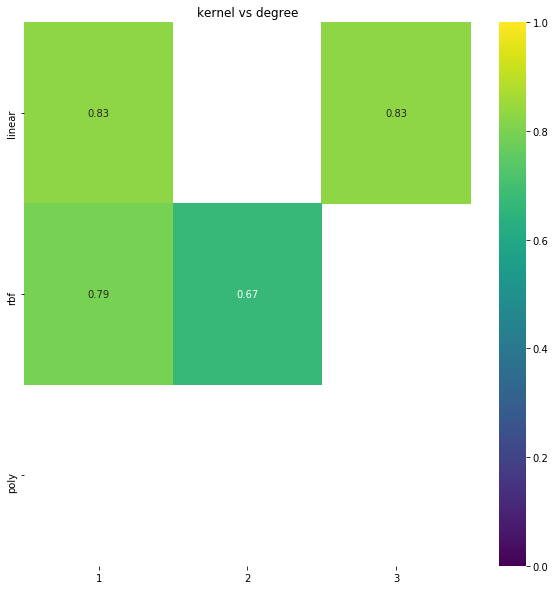

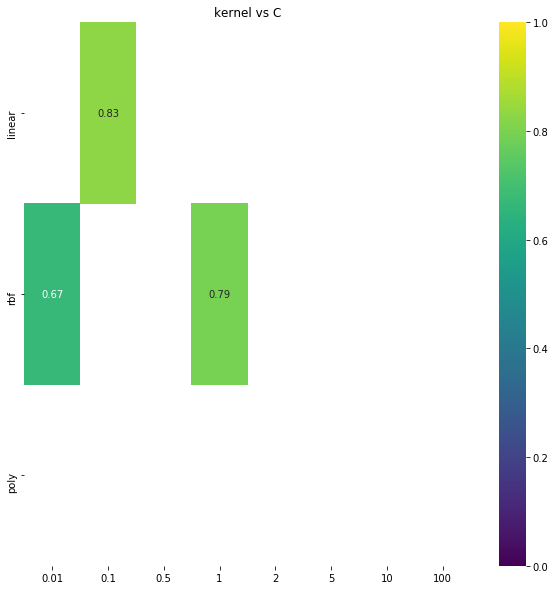

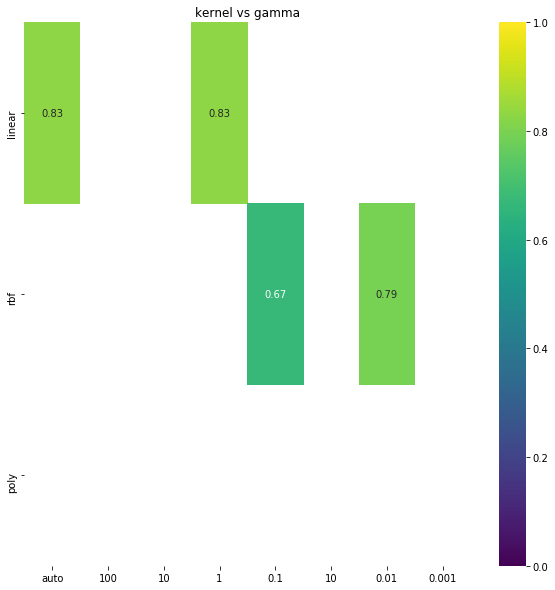

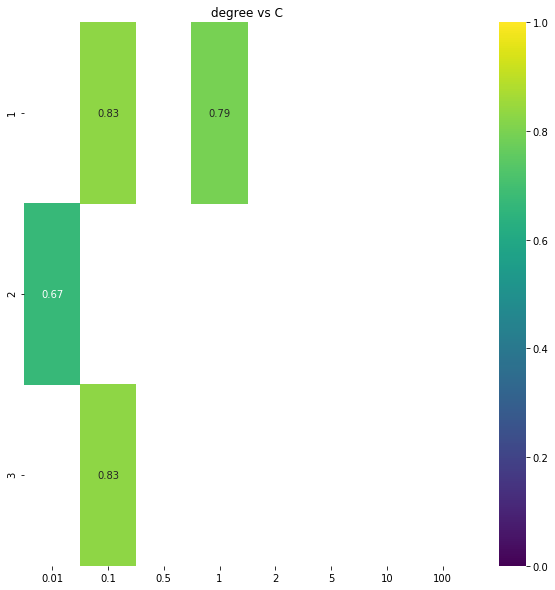

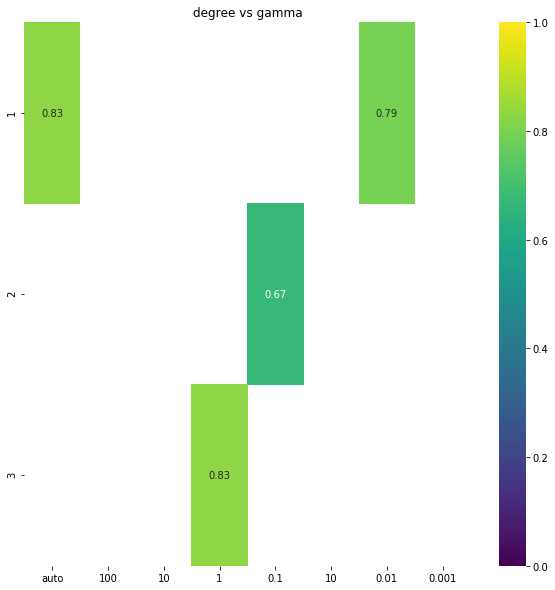

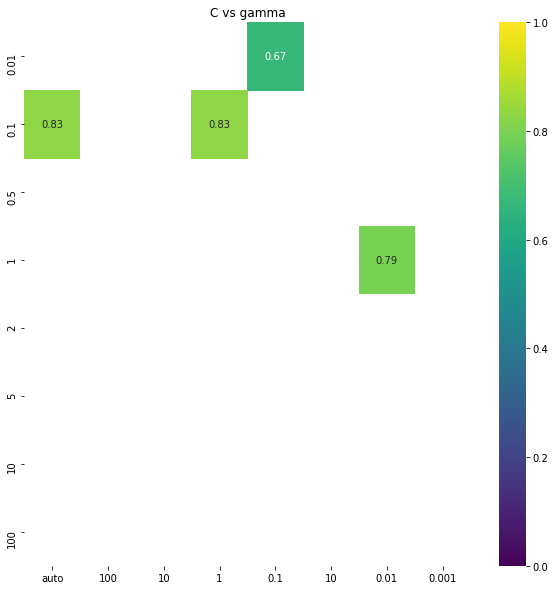

In [135]:
import itertools
import seaborn as sns

listables = []
for key, value in clf.param_distributions.items():
    if isinstance(value, list):
        listables.append(key)

for a, b in itertools.combinations(listables, 2):
#     print(a,b)
    params_a = clf.param_distributions[a]
    params_b = clf.param_distributions[b]
    
    results = []
    for val_a, val_b in itertools.product(params_a, params_b):
        crit_a = clf.cv_results_[f'param_{a}'] == val_a
        crit_b = clf.cv_results_[f'param_{b}'] == val_b
        try:
            best = np.max(clf.cv_results_['mean_test_score'][crit_a & crit_b])
        except ValueError:
            best = np.nan 
        results.append(best)
#         print('\t', val_a, val_b, best)
    results = np.array(results).reshape((len(params_a), len(params_b)))

    plt.figure(figsize=(10,10))
    sns.heatmap(results, xticklabels=params_b, yticklabels=params_a, annot=True, fmt=".2f", vmin=0.0, vmax=1.0, cmap='viridis').set_title(f"{a} vs {b}")

## Old

In [12]:
parameters = {
    'kernel':('linear', 'rbf', 'poly'),
    'degree': (1, 2, 3),
    'C':[0.5, 1, 2, 5],
                    'gamma': ['scale', 'auto', 10, 1, 0.1, 10, 0.01]
}

svc = SVC()
clf = GridSearchCV(svc, parameters, cv=5, verbose=2)

clf.fit(X, y_binary)

clf.cv_results_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] ................. C=0.5, gamma=auto, kernel=linear, total=   0.5s
[CV] C=0.5, gamma=auto, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ................. C=0.5, gamma=auto, kernel=linear, total=   0.4s
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] ................. C=0.5, gamma=auto, kernel=linear, total=   0.4s
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] ................. C=0.5, gamma=auto, kernel=linear, total=   0.4s
[CV] C=0.5, gamma=auto, kernel=linear ................................
[CV] ................. C=0.5, gamma=auto, kernel=linear, total=   0.4s
[CV] C=0.5, gamma=auto, kernel=rbf ...................................
[CV] .................... C=0.5, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=0.5, gamma=auto, kernel=rbf ...................................
[CV] .................... C=0.5, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=0.5, gamma=auto, kernel=rbf ...................................
[CV] .................... C=0.5, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=0.5, gamma=auto, kernel=rbf ...................................
[CV] .

[CV] .................... C=0.5, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ................... C=1, gamma=auto, kernel=linear, total=   0.4s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ................... C=1, gamma=auto, kernel=linear, total=   0.4s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ................... C=1, gamma=auto, kernel=linear, total=   0.4s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ................... C=1, gamma=auto, kernel=linear, total=   0.4s
[CV] C=1, gamma=auto, kernel=linear ..................................
[CV] ................... C=1, gamma=auto, kernel=linear, total=   0.5s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ...................... C=1, gamma=auto, kernel=rbf, total=   0.6s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] .

[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=1, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=2, gamma=auto, kernel=linear ..................................
[CV] ................... C=2, gamma=auto, kernel=linear, total=   0.5s
[CV] C=2, gamma=auto, kernel=linear ..................................
[CV] ................... C=2, gamma=auto, kernel=linear, total=   0.5s
[CV] C=2, gamma=auto, kernel=linear ..................................
[CV] ................... C=2, gamma=auto, kernel=linear, total=   0.5s
[CV] C=2, gamma=auto, kernel=linear ..................................
[CV] ................... C=2, gamma=auto, kernel=linear, total=   0.5s
[CV] C=2, gamma=auto, kernel=linear ..................................
[CV] .

[CV] ...................... C=2, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=2, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=2, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=2, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=2, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=2, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=2, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=2, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=2, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=5, gamma=auto, kernel=linear ..................................
[CV] ................... C=5, gamma=auto, kernel=linear, total=   0.6s
[CV] C=5, gamma=auto, kernel=linear ..................................
[CV] ................... C=5, gamma=auto, kernel=linear, total=   0.7s
[CV] C=5, gamma=auto, kernel=linear ..................................
[CV] .

[CV] ................... C=5, gamma=0.01, kernel=linear, total=   0.7s
[CV] C=5, gamma=0.01, kernel=linear ..................................
[CV] ................... C=5, gamma=0.01, kernel=linear, total=   0.7s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   0.4s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   0.4s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   0.4s
[CV] C=5, gamma=0.01, kernel=rbf .....................................
[CV] ...................... C=5, gamma=0.01, kernel=rbf, total=   0.4s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.3min finished
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/solmyr/Codes/studia/2019-2020-winter/happy-szczurki/.env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which

{'mean_fit_time': array([0.36534381, 0.48396039, 0.35588675, 0.88982787, 0.3568728 ,
        0.83234172, 0.35562863, 0.36769972, 0.35543809, 0.90890059,
        0.37960973, 0.45689502, 0.37576241, 0.46429524, 0.38978477,
        0.92398081, 0.37682209, 0.85732646, 0.39429741, 0.37639503,
        0.40290933, 0.95750837, 0.3917275 , 0.40280404, 0.42567554,
        0.42835922, 0.41206174, 0.89682741, 0.41196876, 0.88191509,
        0.42059317, 0.35535555, 0.41229973, 0.89638081, 0.41585374,
        0.41480751, 0.59649882, 0.42376761, 0.56435442, 0.89913774,
        0.54105215, 0.89920626, 0.54931912, 0.35615392, 0.56484685,
        0.93807216, 0.56227031, 0.36614218]),
 'std_fit_time': array([0.01678882, 0.00926958, 0.01242508, 0.00263376, 0.01274085,
        0.00946888, 0.01254877, 0.01121832, 0.0129638 , 0.02566802,
        0.01695088, 0.02973345, 0.01247635, 0.01635083, 0.03276061,
        0.02161047, 0.01317416, 0.00209183, 0.03115731, 0.02685899,
        0.01822579, 0.03160556, 0.018

In [13]:
clf.best_params_, clf.best_score_
# ({'C': 1, 'degree': 1, 'kernel': 'linear'}, 0.8485)
# ({'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}, 0.8795)

({'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}, 0.884)

In [19]:
evaluate_model(clf.best_estimator_, test_data)

[[3370 5607]
 [  61  962]]
accuracy: 0.4332
precision: 0.5643331761634083
recall: 0.6578876331182404
fscore: 0.39831129717460234
support: Counter({0: 8977, 1: 1023})


(array([198384,  57848, 175379, ..., 153000, 178801,  27358]),
 array([0, 1, 1, ..., 0, 1, 1]),
 array([0, 0, 1, ..., 1, 0, 0]))

In [26]:
# m = SVC(**clf.best_params_)
m = SVC(kernel='poly', degree=1, gamma='auto')
m.fit(X, y_binary)
evaluate_model(m, test_data)

[[8762  180]
 [ 487  571]]
accuracy: 0.9333
precision: 0.853832616445813
recall: 0.7597839088196607
fscore: 0.7973107604982315
support: Counter({0: 8942, 1: 1058})


(array([119472,  30512,  14137, ..., 193984, 109806,   7238]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]))

# Random Forest Classifier #

In [1]:
# from sklearn.ensemble import RandomForestClassifier

# parameters = {
#     'n_estimators': [100, 500, 1000],
#     'max_depth': [20, 40, 100],
# }

# rf = RandomForestClassifier(random_state=0)

# clf = GridSearchCV(rf, parameters, cv=5, verbose=10)

# clf.fit(X, y_binary)

# # clf.cv_results_
# print(clf.best_params_, clf.best_score_)

In [3]:
# print(clf.best_params_, clf.best_score_)

In [2]:
# idx, y_pred, y_true = evaluate_model(rf, train_data)

## Jak oceniać modele? jaka miara? ##
## Jak normalizować dane? potrzebne dla SVMa ##

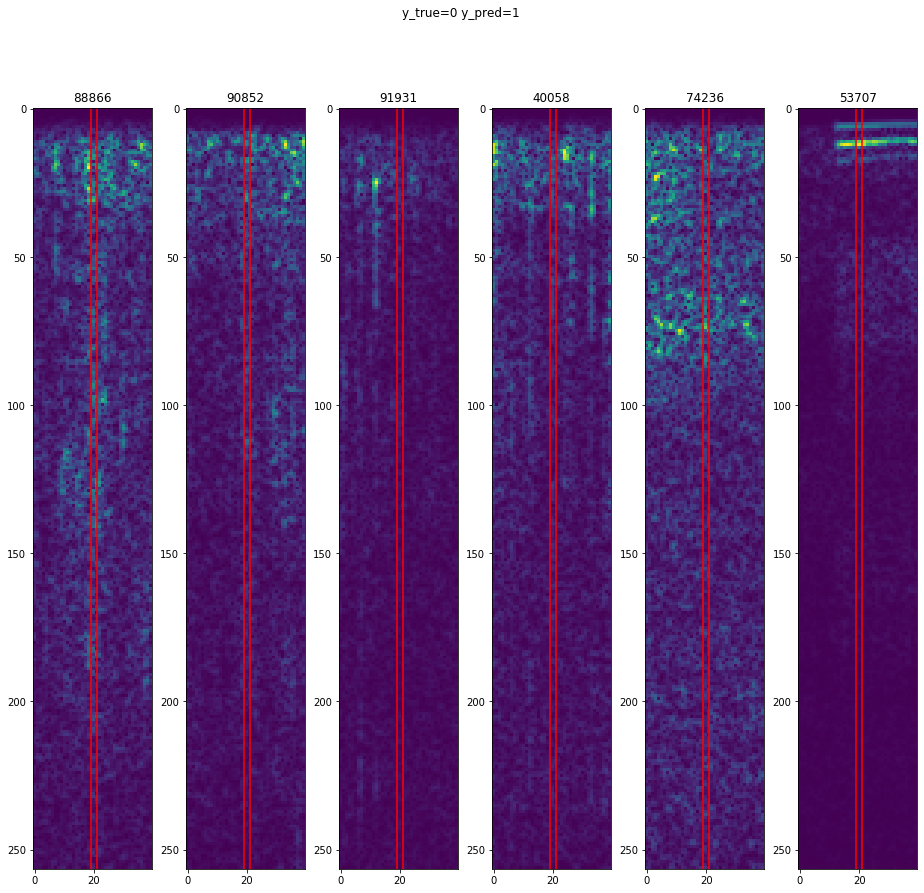

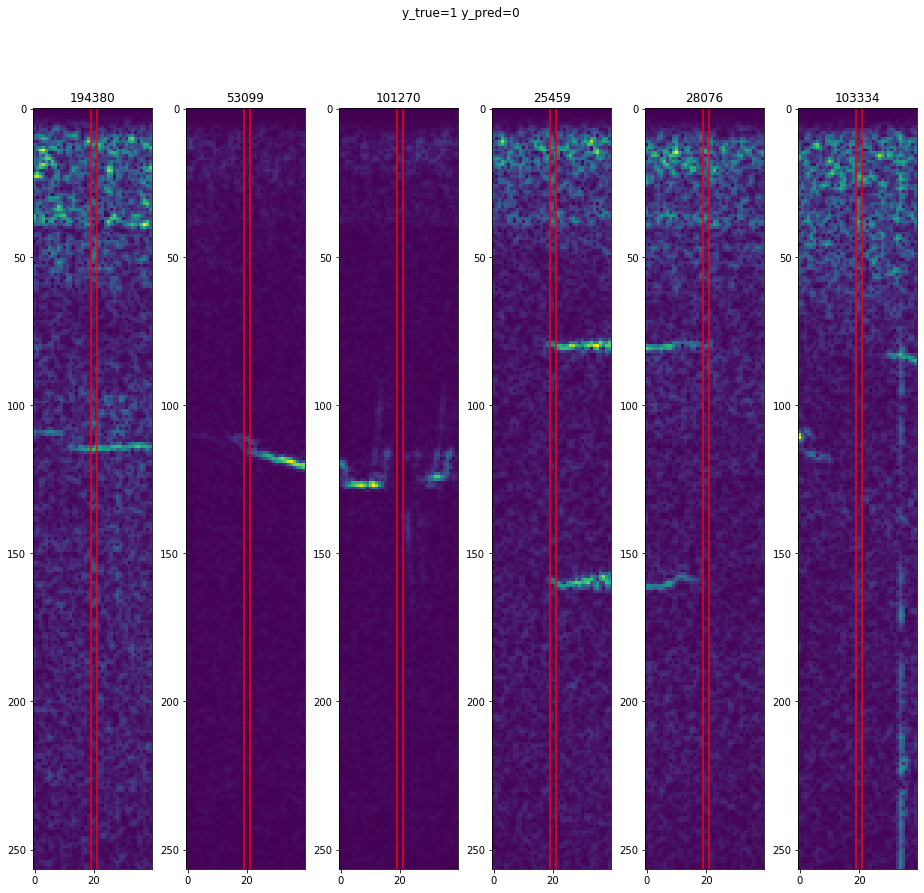

In [88]:
N = 6

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=0 y_pred=1')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==1) & (y_true == 0)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')

################################################
fig, axs = plt.subplots(1, N, figsize=(16, 14))
fig.suptitle('y_true=1 y_pred=0')
for ax, pos in zip(axs, np.random.choice(idx[(y_pred==0) & (y_true == 1)].reshape(-1), N)):
    ax.imshow(test_data.X[pos-20:pos+20].T)
    ax.set_title(f"{pos}")
    ax.axvline(19,color='red')
    ax.axvline(21,color='red')
